In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from scipy.optimize import curve_fit

import scvi
import pickle
from adjustText import adjust_text
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib as mpl

import itertools
import os
import networkx as nx
import networkx.algorithms.community as nx_comm

In [4]:
#skip for later import

#import data and markers
#adata_drop = sc.read_h5ad('../data/tms/tabula-muris-senis-droplet-official-raw-obj.h5ad')
#adata_facs = sc.read_h5ad('../data/tms/tabula-muris-senis-facs-official-raw-obj.h5ad')
adata = sc.read_h5ad('../data/tms/tms-scVI-raw-data.h5ad')


In [5]:
with open('../data/gene_lists/mouse_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role

In [6]:
#add senmayo

senmayo = pd.read_csv('../data/gene_lists/senMayo.csv')['Gene(human)'].values.tolist() #FIX MOUSE
senmayo = [x[0] + x[1:].lower() for x in senmayo]
senmayo = [x for x in senmayo if x not in list(markers)]
senmayo = {x:'senmayo' for x in senmayo}
markers = markers | senmayo

In [4]:
#skip for later import

#harmonize facs and drop datasets
tissue_mapper = {
    'Aorta': 'Heart_and_Aorta',
    'Heart': 'Heart_and_Aorta',
    'Brain_Myeloid': 'Brain',
    'Brain_Non-Myeloid': 'Brain',
    'BAT': 'Fat',
    'GAT': 'Fat',
    'SCAT': 'Fat',
    'MAT': 'Fat'
}

def the_tissue_mapper(x):
    try:
        return tissue_mapper[x]
    except:
        return x

adata.obs['tissue2'] = adata.obs.tissue.map(the_tissue_mapper).astype('category')

In [5]:
#skip for later import

blood_cells_df = pd.read_csv('../data/annotations/blood_cell_annotation.csv')

blood_cells_df['tissue_cell'] = blood_cells_df.tissue2 + "_"+ blood_cells_df.cell_ontology_class

blood_cells_df

,Unnamed: 0,tissue2,cell_ontology_class,blood_cell,tissue_cell
0,21,Bladder,bladder cell,n,Bladder_bladder cell
1,22,Bladder,bladder urothelial cell,n,Bladder_bladder urothelial cell
2,39,Bladder,endothelial cell,n,Bladder_endothelial cell
3,88,Bladder,leukocyte,y,Bladder_leukocyte
4,156,Brain,Bergmann glial cell,n,Brain_Bergmann glial cell
...,...,...,...,...,...
236,2737,Trachea,mesenchymal cell,n,Trachea_mesenchymal cell
237,2738,Trachea,mesenchymal progenitor cell,n,Trachea_mesenchymal progenitor cell
238,2743,Trachea,mucus secreting cell,n,Trachea_mucus secreting cell
239,2749,Trachea,neuroendocrine cell,n,Trachea_neuroendocrine cell


In [6]:
#skip for later import

#make adata of only solid tissues, no blood cells: bloodless
bloodless = adata.copy()
bloodless.obs['tissue_cell'] = bloodless.obs.tissue2.astype('str')\
    + "_"+ bloodless.obs.cell_ontology_class.astype('str')

bloodless = bloodless[bloodless.obs.tissue_cell.isin(blood_cells_df[blood_cells_df.blood_cell == 'n'].tissue_cell)]

bloodless = bloodless[~bloodless.obs.tissue.isin(['Spleen', 'Marrow'])] #getting rid of these beacuase all blood

In [7]:
#skip for later import

bloodless_cell_harmonize = pd.read_csv('../data/annotations/bloodless_cell_harmonize.csv')

bloodless_cell_harmonize = bloodless_cell_harmonize.dropna()

bloodless_cell_harmonize['tissue_cell'] = bloodless_cell_harmonize.tissue2\
+ "_"+ bloodless_cell_harmonize.cell_ontology_class

bloodless_cell_harmonize = dict(zip(bloodless_cell_harmonize.tissue_cell, bloodless_cell_harmonize.cell_type_2))


def bloodless_cell_harmonize_mapper(x):
    tissue, tissue_cell = x
    try:
        return bloodless_cell_harmonize[tissue_cell]
    except:
        return tissue_cell[len(tissue) + 1:]
    
    
bloodless.obs['cell_type_2'] = bloodless.obs[['tissue2', 'tissue_cell']]\
.apply(bloodless_cell_harmonize_mapper, axis = 1)


bloodless.obs['tissue_cell'] = bloodless.obs.tissue2.astype('str')\
+ "_"+ bloodless.obs.cell_type_2.astype('str')

/tmp/ipykernel_31436/3323724220.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  bloodless.obs['cell_type_2'] = bloodless.obs[['tissue2', 'tissue_cell']]\


In [8]:
bloodless.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2
index,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACCTGCAGTAAGCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACCTGTCATTATCC-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACGGGGTACAGTGG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACGGGGTCTTCTCG-1-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_MAA001690_S20.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_54_F,146922.0,3523.0,female,Mammary_Gland,Mammary_Gland,nan,Mammary_Gland,Mammary_Gland_basal cell,basal cell
P8_MAA001700_S104.mus-2-1-1,21m,1,nan,basal cell,NA,basal cell,facs,21_55_F,1027535.0,4476.0,female,Mammary_Gland,Mammary_Gland,nan,Mammary_Gland,Mammary_Gland_basal cell,basal cell
P9_B000485_S69.mus-2-1-1,18m,1,nan,basal cell,NA,basal cell,facs,18_47_F,1184061.0,2980.0,female,Mammary_Gland,Mammary_Gland,nan,Mammary_Gland,Mammary_Gland_basal cell,basal cell


In [9]:
#skip for later import

with open('../data/annotations/blood_cell_mapper.pickle', 'rb') as handle:
     blood_cell_mapper = pickle.load(handle)
        
        
blood = adata.copy()
blood.obs['tissue_cell'] = blood.obs.tissue2.astype('str')\
    + "_"+ blood.obs.cell_ontology_class.astype('str')


blood = blood[(blood.obs.tissue_cell.isin(blood_cells_df[blood_cells_df.blood_cell == 'y'].tissue_cell)) |\
              (blood.obs.tissue.isin(['Spleen', 'Marrow']))]

def get_scvi_annotation(x):
    try:
        return blood_cell_mapper[x]
    except:
        return 'drop'

blood.obs['cell_type_2'] = blood.obs.index.map(get_scvi_annotation)

blood = blood[blood.obs.cell_type_2 != 'drop']

/tmp/ipykernel_31436/2070693892.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  blood.obs['cell_type_2'] = blood.obs.index.map(get_scvi_annotation)


In [10]:
#skip for later import

##split blood tissue2 to myeloid and lymphoid

temp_d = {'plasma cell':'Lymphoid',
 'naive T cell':'Lymphoid',
 'B cell':'Lymphoid',
 'monocyte':'Myeloid',
 'immature B cell':'Lymphoid',
 'NK cell':'Lymphoid',
 'hematopoietic stem cell':'HSC',
 'immature T cell':'Lymphoid',
 'myloid progenitor':'Myeloid',
 'granulocyte':'Myeloid',
 'T cell':'Lymphoid',
 'macrophage':'Myeloid'}


blood.obs['tissue2'] = blood.obs.cell_type_2.map(temp_d) 

/tmp/ipykernel_31436/3182627250.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  blood.obs['tissue2'] = blood.obs.cell_type_2.map(temp_d)


In [11]:
#skip for later import

bdata = bloodless.concatenate(blood)

/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [12]:
#skip for later import

cell_counts = bdata.obs.groupby(['age', 'tissue2', 'cell_type_2'])\
.size().reset_index().rename(columns={0:'Count'})

cell_counts = cell_counts[cell_counts.Count > 0]

tissue_cells = cell_counts[['tissue2', 'cell_type_2']].values.tolist()
tissue_cells = [list(x) for x in set(tuple(x) for x in tissue_cells)]


#if there are enough young and old cells append the tissue_cell type to a list
out = []
for tissue_cell in tissue_cells:
    temp = cell_counts[(cell_counts.tissue2 == tissue_cell[0]) &\
            (cell_counts.cell_type_2 == tissue_cell[1])]
    if (temp[(temp.age == '1m') | (temp.age == '3m')].Count.sum() > 125) & \
            (temp[(temp.age == '24m') | (temp.age == '30m')].Count.sum() > 125):
        out.append(tissue_cell)
        
def filter_func_1(x):
    tissue, cell = x
    if [tissue, cell] in out:
        return True
    else:
        return False
    
    
tissue_cells = out
cell_counts = cell_counts[cell_counts[['tissue2', 'cell_type_2']].apply(filter_func_1, axis = 1)].reset_index(drop = True)




In [13]:
#skip for later import

bdata = bdata[bdata.obs[['tissue2', 'cell_type_2']].apply(filter_func_1, axis = 1)]

In [7]:
bdata = sc.read_h5ad('../data/tms/tms-scVI-raw-data_BDATA.h5ad')

In [6]:
# out = []
# for age_tissue_cell in tqdm(cell_counts.values):
#     age_sub = bdata[(bdata.obs.age == age_tissue_cell[0]) &\
#                     (bdata.obs.tissue2 == age_tissue_cell[1]) &\
#                     (bdata.obs.cell_type_2 == age_tissue_cell[2])].X.toarray()
#     col_out = []
#     for gene in bdata.var_names:
#         i = np.where(bdata.var_names == gene)[0][0]
#         gene_vals = age_sub[:, i]
#         gene_frac = len(gene_vals[gene_vals > 0])/len(gene_vals)
#         if gene_frac == 0 and age_tissue_cell[0] in ['1m', '3m']: #only impute young
#             gene_frac = 1/len(gene_vals) #impute 1/num cells if value is 0
        
#         col_out.append(gene_frac)
#     out.append(col_out)
    
# out = np.array(out)


# cell_counts = pd.concat([cell_counts, pd.DataFrame(out, columns = list(bdata.var_names))], axis = 1)

# cell_counts.to_pickle('../data/files/5_ALL_GENE_cell_counts_TMS.pickle')

##takes about two hours so save to pickle

cell_counts = pd.read_pickle('../data/files/5_ALL_GENE_cell_counts_TMS.pickle')


#frac of each gene
cell_counts

,age,tissue2,cell_type_2,Count,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,...,Uty,Ddx3y,Usp9y,Rbmy1a1,LOC100039753,LOC434960,LOC380994,LOC100041346,Sly,Erdr1
0,1m,Bladder,bladder cell,629,0.001590,0.001590,0.006359,0.332273,0.311606,0.637520,...,0.057234,0.559618,0.001590,0.001590,0.001590,0.001590,0.001590,0.001590,0.001590,0.297297
1,1m,Bladder,bladder urothelial cell,188,0.005319,0.005319,0.010638,0.367021,0.569149,0.606383,...,0.132979,0.696809,0.005319,0.005319,0.005319,0.005319,0.005319,0.005319,0.005319,0.569149
2,1m,Bladder,endothelial cell,118,0.008475,0.008475,0.576271,0.423729,0.355932,0.669492,...,0.101695,0.728814,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.008475,0.440678
3,1m,HSC,hematopoietic stem cell,74,0.013514,0.013514,0.013514,0.770270,0.486486,0.770270,...,0.108108,0.581081,0.013514,0.013514,0.013514,0.013514,0.013514,0.013514,0.013514,0.554054
4,1m,Heart_and_Aorta,endocardial cell,47,0.021277,0.021277,0.148936,0.212766,0.404255,0.446809,...,0.106383,0.553191,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.021277,0.234043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,30m,Myeloid,myloid progenitor,2048,0.000000,0.000000,0.000000,0.449219,0.437012,0.433594,...,0.012207,0.134277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100098
300,30m,Pancreas,pancreatic A cell,50,0.000000,0.000000,0.000000,0.120000,0.100000,0.260000,...,0.080000,0.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000
301,30m,Pancreas,pancreatic B cell,276,0.007246,0.000000,0.003623,0.097826,0.065217,0.250000,...,0.137681,0.380435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.586957
302,30m,Pancreas,pancreatic acinar cell,1953,0.000000,0.000000,0.000000,0.039939,0.015361,0.029698,...,0.001024,0.017921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025090


In [12]:
# cell_stats = pd.DataFrame(columns = ['tissue2', 'cell_type_2','gene', 'start', 'end', 'gain', 'ratio'])

# for tissue_cell in tqdm(tissue_cells):

#     temp = cell_counts[(cell_counts.tissue2 == tissue_cell[0]) &\
#                 (cell_counts.cell_type_2 == tissue_cell[1])]

#     out = []
#     for gene in bdata.var_names:

#         try:
#             c3m = temp.loc[temp.age == '3m', 'Count'].iloc[0]
#             f3m = temp.loc[temp.age == '3m', gene].iloc[0]
#         except:
#             c3m = 0
#             f3m = 0
#         try:
#             c1m = temp.loc[temp.age == '1m', 'Count'].iloc[0]
#             f1m = temp.loc[temp.age == '1m', gene].iloc[0]
#         except:
#             c1m = 0
#             f1m = 0
#         try:
#             c24m = temp.loc[temp.age == '24m', 'Count'].iloc[0]
#             f24m = temp.loc[temp.age == '24m', gene].iloc[0]
#         except:
#             c24m = 0
#             f24m = 0
#         try:
#             c30m = temp.loc[temp.age == '30m', 'Count'].iloc[0]
#             f30m = temp.loc[temp.age == '30m', gene].iloc[0]
#         except:
#             c30m = 0
#             f30m = 0

#         if c3m > 200:
#             young_start = f3m
#         else:
#             young_start = (c3m*f3m + c1m*f1m)/(c3m + c1m)

#         if c30m > 200:
#             old_end = f30m
#         else:
#             old_end = (c30m*f30m + c24m*f24m)/(c30m + c24m)

#         old_gain = old_end - young_start
#         old_ratio = old_end/young_start
        
#         out.append([tissue_cell[0], tissue_cell[1], gene, young_start, old_end, old_gain, old_ratio])

#     temp2 = pd.DataFrame(out, columns = ['tissue2', 'cell_type_2','gene', 'start', 'end', 'gain', 'ratio'])
#     cell_stats = pd.concat([cell_stats, temp2])
    
    
# cell_stats.to_pickle('../data/files/5_ALL_GENE_cell_stats_TMS.pickle')
    

cell_stats = pd.read_pickle('../data/files/5_ALL_GENE_cell_stats_TMS.pickle')
    
    
cell_stats #dataframe of known sen genes and their changes in every cell type (with enough cells)

,tissue2,cell_type_2,gene,start,end,gain,ratio
0,Limb_Muscle,smooth muscle cell,Xkr4,0.004237,0.000000,-0.004237,0.000000
1,Limb_Muscle,smooth muscle cell,Rp1,0.004237,0.000000,-0.004237,0.000000
2,Limb_Muscle,smooth muscle cell,Sox17,0.167373,0.096685,-0.070688,0.577663
3,Limb_Muscle,smooth muscle cell,Mrpl15,0.127119,0.099448,-0.027671,0.782320
4,Limb_Muscle,smooth muscle cell,Lypla1,0.167373,0.146409,-0.020964,0.874746
...,...,...,...,...,...,...,...
20111,Kidney,Henle thick ascending limb epithelial cell,LOC434960,0.003226,0.000000,-0.003226,0.000000
20112,Kidney,Henle thick ascending limb epithelial cell,LOC380994,0.003226,0.000000,-0.003226,0.000000
20113,Kidney,Henle thick ascending limb epithelial cell,LOC100041346,0.003226,0.000000,-0.003226,0.000000
20114,Kidney,Henle thick ascending limb epithelial cell,Sly,0.003226,0.000000,-0.003226,0.000000


In [111]:


# #DEPRECATED WITH R1 !!!!!!!
# #ie, no longer use hard thresholds and instead use null distribution

# def filter_cell_stats(df): #these are all fractions, not percents
#     df = df[df.start < 0.05] #starts below 5%
#     df = df[df.end < 0.2] #ends below 20%
#     df = df[df.end > 0.01] #no genes that end below 1%
    
#     df = df[df.gain > .005] #gains at least 0.5%
#     df = df[(df.ratio > 2.5) | (df.gain > .05)] #raito of at least 2
#     return df


# cell_stats = filter_cell_stats(cell_stats)
# cell_stats['tissue_cell'] = cell_stats.tissue2 + '_' + cell_stats.cell_type_2

In [8]:
#R1
with open('../data/files/R1_FILT_GENES_MOUSE.pickle', 'rb') as f:
    sel = pickle.load(f)

In [9]:
len(sel)

62

In [13]:
cell_stats.cell_type_2 = cell_stats.cell_type_2.map(lambda x: x.strip()) #some have whitespace

In [14]:
cell_stats['tissue.cell'] = cell_stats.tissue2 + '.' + cell_stats.cell_type_2
cell_stats['tissue_cell'] = cell_stats.tissue2 + '_' + cell_stats.cell_type_2

In [15]:
new_stats = []
not_there = []
for tissue_cell in tqdm(cell_stats['tissue.cell'].unique()):
    _ = cell_stats[cell_stats['tissue.cell'] == tissue_cell]
    try:
        _ = _[_.gene.isin(sel[tissue_cell])]
        new_stats.append(_)
    except:
        not_there.append(tissue_cell)
    
    

100%|███████████████████████████████████████████| 62/62 [00:03<00:00, 18.31it/s]


In [16]:
not_there

[]

In [117]:
# #this was to rerun all the cell types even if they weren't senepy sigs, ignore
# with open('R1/better_input_list_mouse.txt', 'w') as f:
#     for x in cell_stats['tissue.cell'].unique():
#         f.write(x + '\n')

In [125]:
# #this was done so I could do all cell types with enough data not just filtered senepy sigs
# for cell_tissue in not_there:
#     tissue, cell = cell_tissue.split('.')
#     _ = bdata[(bdata.obs.tissue2 == tissue) & (bdata.obs.cell_type_2 == cell)].copy()
#     _.write_h5ad(f'R1/temp_adata_subs/{tissue}_{cell}.h5ad')
    

In [17]:
bdata.obs

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,tissue2,tissue_cell,cell_type_2
index,,,,,,,,,,,,,,,,,
AAACCTGCAGGGTACA-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGGGTACA,keratinocyte,NA,filiform,droplet,24-M-60,NaN,2107.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACCTGCAGTAAGCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGCAGTAAGCG,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,3481.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACCTGTCATTATCC-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACCTGTCATTATCC,keratinocyte,NA,suprabasal,droplet,24-M-60,NaN,2599.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACGGGGTACAGTGG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTACAGTGG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3468.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
AAACGGGGTCTTCTCG-1-0-0-0-0-0,24m,0,MACA_24m_M_TONGUE_60_AAACGGGGTCTTCTCG,keratinocyte,NA,suprabasal differentiating,droplet,24-M-60,NaN,3189.0,male,nan,Tongue,Tongue,Tongue,Tongue_keratinocyte,keratinocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA001844.3_38_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B,facs,3_38_F,800879.0,2988.0,female,KLS,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell
P9.MAA001883.3_39_F.1.1-1-1-1-1,3m,1,nan,naive B cell,CL:0000788,naïve B cell,facs,3_39_F,198660.0,1867.0,female,B-cells,Marrow,nan,Lymphoid,Marrow_naive B cell,B cell
P9.MAA001887.3_39_F.1.1-1-1-1-1,3m,1,nan,hematopoietic stem cell,CL:0002035,MPP Fraction B + C,facs,3_39_F,227378.0,2919.0,female,KLS,Marrow,nan,HSC,Marrow_hematopoietic stem cell,hematopoietic stem cell


In [18]:
len(cell_stats['tissue.cell'].unique())

62

In [34]:
len(new_stats) #should be same length as sel

62

In [35]:
len(sel)

62

In [36]:
cell_stats = pd.concat(new_stats) #overwriting cell_stats with R1 filtered stats

In [29]:
#how many genes in each cell context
how_many = cell_stats.groupby(['tissue2', 'cell_type_2']).count().reset_index()\
.sort_values('gene', ascending = False).reset_index(drop = True)

how_many

,tissue2,cell_type_2,gene,start,end,gain,ratio,tissue.cell,tissue_cell
0,Liver,Kupffer cell,4450,4450,4450,4450,4450,4450,4450
1,Liver,hepatocyte,1750,1750,1750,1750,1750,1750,1750
2,Trachea,macrophage,1402,1402,1402,1402,1402,1402,1402
3,Kidney,collecting duct principal cell,1361,1361,1361,1361,1361,1361,1361
4,Thymus,thymocyte,1216,1216,1216,1216,1216,1216,1216
...,...,...,...,...,...,...,...,...,...
57,Skin,bulge keratinocyte,28,28,28,28,28,28,28
58,Myeloid,granulocyte,23,23,23,23,23,23,23
59,Brain,neuron,22,22,22,22,22,22,22
60,Bladder,bladder urothelial cell,16,16,16,16,16,16,16


In [30]:
how_many[how_many.tissue2 == 'Lung']

,tissue2,cell_type_2,gene,start,end,gain,ratio,tissue.cell,tissue_cell
6,Lung,fibroblast,994,994,994,994,994,994,994
33,Lung,alveolar macrophage,159,159,159,159,159,159,159
39,Lung,smooth muscle cell,117,117,117,117,117,117,117


In [31]:
len(cell_stats[(cell_stats.tissue2 == 'Lung') &\
                    (cell_stats.cell_type_2 == 'fibroblast')].gene.tolist())

994

In [37]:
!mv ../data/files/tms_corr_subs/*h5ad ../data/files/tms_corr_subs/bak

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [38]:
#make subset adata
for tissue_cell in tqdm(cell_stats['tissue.cell'].unique()):
    _ = cell_stats[cell_stats['tissue.cell'] == tissue_cell]
    tissue = _.iloc[0].tissue2
    cell = _.iloc[0].cell_type_2
    genes = _.gene.tolist()
    sdata = bdata[(bdata.obs.tissue2 == tissue) & (bdata.obs.cell_type_2 == cell) &\
                      (bdata.obs.age.isin(['21m', '24m', '30m']))][:,genes].copy()

    out_str = '../data/files/tms_corr_subs/' + tissue + '__' + cell + '.h5ad'
    out_str = out_str.replace(' ','_')
    sdata.write_h5ad(out_str)

100%|███████████████████████████████████████████| 62/62 [00:03<00:00, 19.69it/s]


In [48]:
# #make subset adata

# for i in tqdm(range(len(how_many))):
#     tissue = how_many.iloc[i].tissue2
#     cell = how_many.iloc[i].cell_type_2
#     genes = cell_stats[(cell_stats.tissue2 == tissue) &\
#                     (cell_stats.cell_type_2 == cell)].gene.tolist()
    

#     sdata = bdata[(bdata.obs.tissue2 == tissue) & (bdata.obs.cell_type_2 == cell) &\
#                       (bdata.obs.age.isin(['21m', '24m', '30m']))][:,genes]

#     out_str = '../data/files/tms_corr_subs/' + tissue + '__' + cell + '.h5ad'
#     out_str = out_str.replace(' ','_')
    
    
#     if len(sdata) < 100:
#         print('adfadfadfadasdfdf')
#         print('adfadfadfadasdfdf')
#         print('adfadfadfadasdfdf')
#         print('adfadfadfadasdfdf')
#         print('adfadfadfadasdfdf')
#         print('adfadfadfadasdfdf')
#         print('adfadfadfadasdfdf')
#         break
    
    
#     if tissue != 'unknown':
#         sdata.write_h5ad(out_str)  
    
    

 87%|█████████████████████████████████████▍     | 54/62 [00:29<00:05,  1.48it/s]/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
 89%|██████████████████████████████████████▏    | 55/62 [00:29<00:04,  1.62it/s]/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
 90%|██████████████████████████████████████▊    | 56/62 [00:30<00:03,  1.67it/s]/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
 92%|███████████████████████████████████████▌   | 57/62 [00:30<00:02,  1.80it/s]/home/ubuntu/miniconda3/envs/sc/lib/python3.10/site-package

In [ ]:
'''
Each of the tissue/cell/gene datasets were subset and saved to a file, then this was run on each with:
for file in *.h5ad; do python ../s3_mount/senescence/paper_1/Notebooks/scripts/do_corrs_TMS.py "$file" 30; done

then: mv tms_corr_subs/out_dir/ tms_corr
'''

## Import corrs, filter non-sig, network filter --> signatures

In [39]:
corr_path = '../data/files/tms_corr/'

corr_files = os.listdir('../data/files/tms_corr/')

corrs = pd.concat([pd.read_pickle(corr_path + x) for x in corr_files])
corrs['dif'] = corrs.r - corrs.rnd_r_q99
corrs

,tissue,cell_type_2,gene1,gene2,r,p,rnd_r_q99,dif
0,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Pard3b,0.032643,0.054,0.048874,-0.016231
1,Kidney,epithelial cell of proximal tubule,2610017I09Rik,D630023F18Rik,-0.031580,0.950,0.045258,-0.076838
2,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Irs1,-0.026245,0.866,0.053031,-0.079276
3,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Ugt1a2,0.023240,0.098,0.043035,-0.019794
4,Kidney,epithelial cell of proximal tubule,2610017I09Rik,2310007B03Rik,0.044501,0.010,0.044584,-0.000083
...,...,...,...,...,...,...,...,...
79396,Tongue,basal cell,Slitrk2,Vsig4,0.076475,0.000,0.051941,0.024534
79397,Tongue,basal cell,Slitrk2,Cxcr3,0.036111,0.084,0.055300,-0.019188
79398,Tongue,basal cell,Bgn,Vsig4,0.370404,0.000,0.045190,0.325213
79399,Tongue,basal cell,Bgn,Cxcr3,0.177015,0.000,0.050019,0.126996


In [44]:
corrs_sig = corrs[(corrs.r > corrs.rnd_r_q99) & (corrs.r > 0) & (corrs.dif > 0.05)]
corrs_sig

,tissue,cell_type_2,gene1,gene2,r,p,rnd_r_q99,dif
27,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Gm11428,0.102318,0.0,0.044560,0.057758
31,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Apob,0.114168,0.0,0.049032,0.065137
37,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Acot3,0.162751,0.0,0.046656,0.116096
40,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Serpina1d,0.118663,0.0,0.051191,0.067472
56,Kidney,epithelial cell of proximal tubule,2610017I09Rik,Prlr,0.199145,0.0,0.047536,0.151609
...,...,...,...,...,...,...,...,...
79384,Tongue,basal cell,Cxcr6,Vsig4,0.191725,0.0,0.056147,0.135578
79395,Tongue,basal cell,Slitrk2,Bgn,0.124133,0.0,0.045229,0.078905
79398,Tongue,basal cell,Bgn,Vsig4,0.370404,0.0,0.045190,0.325213
79399,Tongue,basal cell,Bgn,Cxcr3,0.177015,0.0,0.050019,0.126996


In [45]:
corrs_sig.groupby(['tissue', 'cell_type_2']).size().reset_index().sort_values(0)

,tissue,cell_type_2,0
51,Pancreas,pancreatic acinar cell,2
1,Bladder,bladder urothelial cell,4
26,Large_Intestine,enterocyte,5
5,Brain,neuron,7
25,Large_Intestine,crypt stem cell,16
...,...,...,...
60,Trachea,macrophage,56163
18,Kidney,collecting duct principal cell,60201
55,Thymus,thymocyte,74420
35,Liver,Kupffer cell,323715


In [46]:
temp = corrs.groupby(['tissue', 'cell_type_2']).size().reset_index().rename(columns={0:'count'})

temp2 = corrs_sig.groupby(['tissue', 'cell_type_2']).size().reset_index().rename(columns={0:'count'})

In [47]:
def raw_gene_num(x):
    sub = corrs[(corrs.tissue == x.tissue) & (corrs.cell_type_2 == x.cell_type_2)]
    return len(list(set(sub.gene1.tolist() + sub.gene2.tolist())))

def filt_gene_num(x):
    sub = corrs_sig[(corrs_sig.tissue == x.tissue) & (corrs_sig.cell_type_2 == x.cell_type_2)]
    return len(list(set(sub.gene1.tolist() + sub.gene2.tolist())))

In [48]:
corr_counts = pd.merge(temp, temp2,  how='left', 
                       left_on=['tissue','cell_type_2'], right_on = ['tissue','cell_type_2'])

corr_counts['per_filt'] = (corr_counts.count_x - corr_counts.count_y)/corr_counts.count_x * 100

tqdm.pandas()
corr_counts['raw_gene_num'] = corr_counts.progress_apply(raw_gene_num, axis = 1)




tqdm.pandas()
corr_counts['filt_gene_num'] = corr_counts.progress_apply(filt_gene_num, axis = 1)

100%|███████████████████████████████████████████| 62/62 [00:07<00:00,  7.98it/s]


In [49]:
corr_counts

,tissue,cell_type_2,count_x,count_y,per_filt,raw_gene_num,filt_gene_num
0,Bladder,bladder cell,12090,1276.0,89.445823,156,147
1,Bladder,bladder urothelial cell,120,4.0,96.666667,16,6
2,Bladder,endothelial cell,4278,149.0,96.517064,93,74
3,Brain,endothelial cell,1225,27.0,97.795918,50,29
4,Brain,microglial cell,8778,1549.0,82.353611,133,106
...,...,...,...,...,...,...,...
57,Tongue,basal cell,79401,8408.0,89.410713,399,384
58,Tongue,keratinocyte,176121,43657.0,75.211928,594,579
59,Trachea,basal cell,105570,3257.0,96.914843,460,441
60,Trachea,fibroblast,648091,40373.0,93.770474,1139,1134


In [50]:
corr_counts.sort_values('filt_gene_num')

,tissue,cell_type_2,count_x,count_y,per_filt,raw_gene_num,filt_gene_num
54,Skin,bulge keratinocyte,378,NaN,NaN,28,0
51,Pancreas,pancreatic acinar cell,28,2.0,92.857143,8,4
1,Bladder,bladder urothelial cell,120,4.0,96.666667,16,6
26,Large_Intestine,enterocyte,406,5.0,98.768473,29,8
5,Brain,neuron,231,7.0,96.969697,22,9
...,...,...,...,...,...,...,...
56,Thymus,thymocyte,738720,74420.0,89.925818,1216,1201
18,Kidney,collecting duct principal cell,925480,60201.0,93.495159,1361,1360
61,Trachea,macrophage,982101,56163.0,94.281342,1402,1402
37,Liver,hepatocyte,1530375,476741.0,68.848093,1750,1750


In [51]:
def make_network(edges, graph = True):
    G = nx.Graph()
    #G = nx.petersen_graph()

    

    for i, elrow in edges.iterrows():
        G.add_edge(elrow[2], elrow[3], weight=elrow[7])



    clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
    clusters = [list(x) for x in clusters]
    
    if not graph:
        return clusters, dict(nx.degree(G))
    
    pos = nx.spring_layout(G, seed = 1) #seed = 1
    
    plt.figure(figsize=(10,10))
    colors = plt.cm.tab20(range(20))
    color_d = {}
    Ecolor_d = {}
    for combo in list(zip(clusters, colors)):
        for thing in combo[0]:
            color_d[thing] = combo[1]
            if thing not in list(markers):
                Ecolor_d[thing] = combo[1]
            else:
                Ecolor_d[thing] = 'magenta'



    node_lables = {}
    for node in list(G.nodes(data=True)):
        if node[0] in list(markers):
            node_lables[node[0]] = node[0]

    nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
                            font_weight='bold')


    nx.draw_networkx_nodes(G, pos, 
                           node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
                           edgecolors = [Ecolor_d[x[0]] for x in list(G.nodes(data=True))])
    nx.draw_networkx_edges(G, pos)


    plt.show()

In [52]:
def remove_lonely_genes(cluster):
        return [x for x in cluster if degrees[x] >= round(np.log(len(cluster)))]



hubs = {} #individual signature clusters
signatures = {} #all genes for tissue_cell that pass filtering
hub_Ms = {} #NxN matrix for hubs

for x in tqdm(range(len(corr_counts))):
    tissue = corr_counts.iloc[x].tissue
    cell = corr_counts.iloc[x].cell_type_2
    tester = corrs_sig[(corrs_sig.tissue == tissue) & (corrs_sig.cell_type_2 == cell)]\
    .copy().sort_values('dif', ascending = False)

    if len(tester) > 0:
        clusters, degrees = make_network(tester, graph = False)


        clusters = [x for x in clusters if len(x) >= 5 ] #remove small clusters
        clusters = [remove_lonely_genes(x) for x in clusters] #remove genes that are loosely connected to clusters

        signature = [] #combine cluster genes into one signature
        for cluster in clusters:
            for gene in cluster:
                signature.append(gene)

        #filter corrs based on signature
        filtered = tester[(tester.tissue == tissue) &\
                      (tester.cell_type_2 == cell) &\
                      ((tester.gene1.isin(signature)) & (tester.gene2.isin(signature)))]
        
        
        
#         #all to make NxN matrix
#         filtered_all = filtered[(corrs.tissue == tissue) &\
#                       (filtered.cell_type_2 == cell) &\
#                       ((filtered.gene1.isin(signature)) & (corrs.gene2.isin(signature)))]

        
        if len(filtered) > 0:
            clusters, degrees = make_network(filtered, graph = False) #redo based on filtered
        signature = [] #combine cluster genes into one signature
        for cluster in clusters:
            for gene in cluster:
                signature.append(gene)

        clusters = [[(y, degrees[y]) for y in x] for x in clusters] #add number of connections per gene
        
        

        signatures[(tissue, cell)] = [(x, degrees[x]) for x in signature] #add to signatures dict
        
        
        
        #this section is to just add redundant and self vs self corrs to make full NxN matrix subsequently
        vals = np.unique(filtered[['gene1', 'gene2']])
        temp = []
        #add a self-corr for each, should it be 1 or should it be 0 though?
        for item in vals:
            temp.append(['x', 'y', item, item, 1, 0, 0, 1])
        comb = pd.concat((filtered,
                          filtered.rename(columns = {'gene1':'gene2', 'gene2':'gene1'}),
                          pd.DataFrame(temp,columns = ['tissue','cell_type_2','gene1','gene2','r','p','rnd_r_q99','dif'])))
        
        
        for x, cluster in enumerate(clusters):
            hubs[(tissue, cell, x)] = cluster #add to hubs dict
            #make corr matrix of genes, NxN matrix based on hubs
            #filter only genes in the hub
            hub_M = comb[(comb.gene1.isin([x[0] for x in cluster])) & (comb.gene2.isin([x[0] for x in cluster]))]
            vals_hub = np.unique(hub_M[['gene1', 'gene2']])
            hub_M = hub_M.pivot(index = 'gene1', columns = 'gene2', values = 'dif')\
            .reindex(columns=vals_hub, index=vals_hub)
            hub_M = hub_M.fillna(0.01)
            hub_Ms[(tissue, cell, x)] = hub_M
    

  0%|                                                    | 0/62 [00:00<?, ?it/s]/tmp/ipykernel_1381197/1653591471.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])
  2%|▋                                           | 1/62 [00:00<00:18,  3.25it/s]/tmp/ipykernel_1381197/1653591471.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])
  3%|█▍                                          | 2/62 [00:00<00:12,  4.91it/s]/tmp/ipykernel_1381197/1653591471.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

In [53]:
signatures = {k:v for (k,v) in signatures.items() if len(signatures[k]) != 0}
hubs = {k:v for (k,v) in hubs.items() if len(hubs[k]) != 0}
hub_Ms = {k:v for (k,v) in hub_Ms.items() if len(hubs[k]) != 0}

In [54]:
len(signatures)

57

In [55]:
hub_metadata = []
for hub in list(hubs):
    
    genes = hubs[hub]
    
    sen = [x for x in genes if x[0] in markers]
    
    if len(sen) > 0:
        hyp = stats.hypergeom.sf(len(sen)-1, len(bdata.var_names), len(genes), len(markers))
    else:
        hyp = 1
    
    
    hub_metadata.append([hub[0], hub[1], hub[2], len(genes), len(sen), hyp])
    
    
hub_metadata = pd.DataFrame(hub_metadata, columns = ['tissue', 'cell', 'hub_num', 'size', 'n_sen', 'hyp'])
hub_metadata

,tissue,cell,hub_num,size,n_sen,hyp
0,Bladder,bladder cell,0,36,0,1.000000e+00
1,Bladder,bladder cell,1,20,0,1.000000e+00
2,Bladder,bladder cell,2,67,3,2.352239e-02
3,Bladder,endothelial cell,0,13,0,1.000000e+00
4,Bladder,endothelial cell,1,6,0,1.000000e+00
...,...,...,...,...,...,...
118,Trachea,basal cell,2,289,14,4.628384e-07
119,Trachea,fibroblast,0,808,27,5.751673e-09
120,Trachea,fibroblast,1,102,2,2.394198e-01
121,Trachea,macrophage,0,228,1,8.784059e-01


In [56]:
with open('../data/files/R1_TMS_HUBS_DICTIONARY.pickle', 'wb') as handle:
    pickle.dump(hubs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
hub_metadata.to_pickle('../data/files/R1_TMS_HUBS_METADATA.pickle')


with open('../data/files/R1_TMS_HUBS_NxN_corrs.pickle', 'wb') as handle:
    pickle.dump(hub_Ms, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
   
    
with open('../data/files/R1_TMS_HUBS_DICTIONARY.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/R1_TMS_HUBS_METADATA.pickle')


with open('../data/files/R1_TMS_HUBS_NxN_corrs.pickle', 'rb') as handle:
    hub_Ms = pickle.load(handle)


In [58]:
sig_metadata = []
for sig in list(signatures):
    
    genes = signatures[sig]
    
    sen = [x for x in genes if x[0] in markers]
    
    if len(sen) > 0:
        hyp = stats.hypergeom.sf(len(sen)-1, len(bdata.var_names), len(genes), len(markers))
    else:
        hyp = 1
    
    
    sig_metadata.append([sig[0], sig[1], len(genes), len(sen), hyp])
    
    
sig_metadata = pd.DataFrame(sig_metadata, columns = ['tissue', 'cell', 'size', 'n_sen', 'hyp'])




with open('../data/files/R1_TMS_SIGS_DICTIONARY.pickle', 'wb') as handle:
    pickle.dump(signatures, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
sig_metadata.to_pickle('../data/files/R1_TMS_SIGS_METADATA.pickle')
    
    
with open('../data/files/R1_TMS_SIGS_DICTIONARY.pickle', 'rb') as handle:
    signatures = pickle.load(handle)
    
sig_metadata = pd.read_pickle('../data/files/R1_TMS_SIGS_METADATA.pickle')

In [59]:
#filter hubs that have fewer than 20 genes or are not enriched for sen markers
hub_metadata = hub_metadata[(hub_metadata['size'] >= 20) | (hub_metadata.hyp < 0.05)].reset_index(drop = True)

In [60]:
#filter sigs that have fewer than 20 genes or are not enriched for sen markers
sig_metadata = sig_metadata[(sig_metadata['size'] >= 30) | (sig_metadata.hyp < 0.05)].reset_index(drop = True)

In [61]:
#filter hubs out of hubs dict by if they are in the hub metadata
def hub_in_metadata(x):
    if len(hub_metadata[(hub_metadata.tissue == x[0]) &\
                        (hub_metadata.cell == x[1]) &\
                        (hub_metadata.hub_num == x[2])]) == 1:
        return True
    else:
        return False
    
hubs = {k:v for (k,v) in hubs.items() if hub_in_metadata(k)}

In [62]:
#filter sigs out of sigs dict by if they are in the sig metadata
def sig_in_metadata(x):
    if len(sig_metadata[(sig_metadata.tissue == x[0]) &\
                        (sig_metadata.cell == x[1])]) == 1:
        return True
    else:
        return False
    
signatures = {k:v for (k,v) in signatures.items() if sig_in_metadata(k)}

In [22]:
#filtered hubs



# with open('../data/files/R1_TMS_HUBS_DICTIONARY_FILTERED.pickle', 'wb') as handle:
#     pickle.dump(hubs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# hub_metadata.to_pickle('../data/files/R1_TMS_HUBS_METADATA_FILTERED.pickle')

    
    
with open('../data/files/R1_TMS_HUBS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    hubs = pickle.load(handle)
    
hub_metadata = pd.read_pickle('../data/files/R1_TMS_HUBS_METADATA_FILTERED.pickle')



In [21]:
#filtered sigs



# with open('../data/files/R1_TMS_SIGS_DICTIONARY_FILTERED.pickle', 'wb') as handle:
#     pickle.dump(signatures, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# sig_metadata.to_pickle('../data/files/R1_TMS_SIGS_METADATA_FILTERED.pickle')
    
    
with open('../data/files/R1_TMS_SIGS_DICTIONARY_FILTERED.pickle', 'rb') as handle:
    signatures = pickle.load(handle)
    
sig_metadata = pd.read_pickle('../data/files/R1_TMS_SIGS_METADATA_FILTERED.pickle')

In [23]:
len(signatures)

43

In [24]:
len(sig_metadata)

43

In [25]:
len(hub_metadata)

72

In [26]:
len(hubs)

72

In [27]:
import senepy as sp

In [28]:
og = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')

In [29]:
len(og.hubs)

43

In [30]:
ogs = list(og.metadata.tissue + og.metadata.cell)

In [31]:
[x for x in sig_metadata.tissue + sig_metadata.cell if x not in ogs] #sigs added

[]

In [32]:
[x for x in ogs if x not in list(sig_metadata.tissue + sig_metadata.cell)] #sigs removed

[]

# similarity between signatures

In [4]:
#import senepy as sp

In [5]:
#hubs = sp.load_hubs(species = 'Mouse', sig_type = 'cell_type')

In [6]:
#signatures = hubs.hubs
#sig_metadata = hubs.metadata

In [33]:
from scipy import spatial

In [34]:
combos = list(itertools.combinations(list(signatures), 2))
#combos = list(itertools.product(list(signatures), list(signatures)))
combos

[(('Bladder', 'bladder cell'), ('Bladder', 'endothelial cell')),
 (('Bladder', 'bladder cell'), ('Brain', 'microglial cell')),
 (('Bladder', 'bladder cell'), ('Diaphragm', 'mesenchymal stem cell')),
 (('Bladder', 'bladder cell'),
  ('Diaphragm', 'skeletal muscle satellite cell')),
 (('Bladder', 'bladder cell'), ('Fat', 'endothelial cell')),
 (('Bladder', 'bladder cell'), ('Fat', 'mesenchymal stem cell')),
 (('Bladder', 'bladder cell'), ('HSC', 'hematopoietic stem cell')),
 (('Bladder', 'bladder cell'), ('Heart_and_Aorta', 'endocardial cell')),
 (('Bladder', 'bladder cell'), ('Heart_and_Aorta', 'endothelial cell')),
 (('Bladder', 'bladder cell'), ('Heart_and_Aorta', 'fibroblast')),
 (('Bladder', 'bladder cell'), ('Heart_and_Aorta', 'myocyte')),
 (('Bladder', 'bladder cell'), ('Heart_and_Aorta', 'smooth muscle cell')),
 (('Bladder', 'bladder cell'),
  ('Kidney', 'Henle thick ascending limb epithelial cell')),
 (('Bladder', 'bladder cell'), ('Kidney', 'collecting duct principal cell')),
 

In [95]:
#calculate "importance" of each gene to signature by the number of edges, normalize by total nodes

# out = []
# for combo in tqdm(combos):
#     test1 = signatures[combo[0]]
#     test2 = signatures[combo[1]]
#     test1 = pd.DataFrame(test1)
#     test1[1] = test1[1]/len(test1)
#     test2 = pd.DataFrame(test2)
#     test2[1] = test2[1]/len(test2)
#     vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
#     vals = vals.fillna(0)
#     result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
#     out.append([combo[0][0] + '__' + combo[0][1], combo[1][0] + '__' + combo[1][1], result])
    
# cs_df = pd.DataFrame(out, columns = ['tissue_cell1', 'tissue_cell2', 'cs'])

In [96]:
#cs_df.sort_values('p_value')

In [35]:
def permutation_test(similarity, vals, n_permutations=1000):
    permuted_similarities = []
    for _ in range(n_permutations):
        shuffled_weights = np.random.permutation(vals['1_y'].values)
        permuted_similarity = 1 - spatial.distance.cosine(vals['1_x'], shuffled_weights)
        permuted_similarities.append(permuted_similarity)
    p_value = (np.sum(np.array(permuted_similarities) >= similarity) + 1) / (n_permutations + 1)
    return p_value

def hyp(l1, l2, bg):
    overlap = [x for x in l1 if x in l2]
    return stats.hypergeom.sf(len(overlap) - 1, bg, len(l1), len(l2))
    
out = []
bg = len(adata.var_names)
for combo in tqdm(combos):
    test1 = signatures[combo[0]]
    test2 = signatures[combo[1]]
    test1 = pd.DataFrame(test1)
    test1[1] = test1[1]/len(test1)
    test2 = pd.DataFrame(test2)
    test2[1] = test2[1]/len(test2)
    vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
    vals = vals.fillna(0)
    result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
    
    
    p_value = hyp(test1[0].tolist(),test2[0].tolist(), bg)
    
    out.append([combo[0][0] + '__' + combo[0][1], combo[1][0] + '__' + combo[1][1], result, p_value])
cs_df = pd.DataFrame(out, columns = ['tissue_cell1', 'tissue_cell2', 'cs', 'p_value'])
cs_df['padj'] =  cs_df.p_value * len(cs_df)

100%|████████████████████████████████████████| 903/903 [00:03<00:00, 281.34it/s]


In [36]:
cs_df.sort_values('cs')

,tissue_cell1,tissue_cell2,cs,p_value,padj
607,Kidney__macrophage,Large_Intestine__secretory cell,0.000000,1.000000e+00,9.030000e+02
109,Brain__microglial cell,Lung__alveolar macrophage,0.000000,1.000000e+00,9.030000e+02
718,Large_Intestine__secretory cell,Lung__alveolar macrophage,0.000000,1.000000e+00,9.030000e+02
105,Brain__microglial cell,Limb_Muscle__smooth muscle cell,0.000000,1.000000e+00,9.030000e+02
716,Large_Intestine__secretory cell,Liver__endothelial cell of hepatic sinusoid,0.000000,1.000000e+00,9.030000e+02
...,...,...,...,...,...
897,Tongue__keratinocyte,Trachea__basal cell,0.376286,1.235802e-98,1.115929e-95
900,Trachea__basal cell,Trachea__fibroblast,0.414397,2.620658e-150,2.366454e-147
835,Lung__fibroblast,Trachea__fibroblast,0.493315,2.631545e-184,2.376285e-181
123,Diaphragm__mesenchymal stem cell,Diaphragm__skeletal muscle satellite cell,0.610706,4.632736e-177,4.183360e-174


In [37]:
cs_df[cs_df.padj < 0.05]

,tissue_cell1,tissue_cell2,cs,p_value,padj
0,Bladder__bladder cell,Bladder__endothelial cell,0.084485,2.551099e-06,2.303642e-03
4,Bladder__bladder cell,Fat__endothelial cell,0.069336,6.713713e-10,6.062483e-07
5,Bladder__bladder cell,Fat__mesenchymal stem cell,0.063304,1.544938e-09,1.395079e-06
7,Bladder__bladder cell,Heart_and_Aorta__endocardial cell,0.078164,4.875679e-11,4.402738e-08
9,Bladder__bladder cell,Heart_and_Aorta__fibroblast,0.061230,7.244759e-09,6.542018e-06
...,...,...,...,...,...
898,Tongue__keratinocyte,Trachea__fibroblast,0.361216,2.944211e-104,2.658623e-101
899,Tongue__keratinocyte,Trachea__macrophage,0.243516,3.486359e-31,3.148183e-28
900,Trachea__basal cell,Trachea__fibroblast,0.414397,2.620658e-150,2.366454e-147
901,Trachea__basal cell,Trachea__macrophage,0.204474,6.002778e-38,5.420509e-35


In [93]:
# #same thing as above but calculates p value based on permutation

# def permutation_test(similarity, vals, n_permutations=1000):
#     permuted_similarities = []
#     for _ in range(n_permutations):
#         shuffled_weights = np.random.permutation(vals['1_y'].values)
#         permuted_similarity = 1 - spatial.distance.cosine(vals['1_x'], shuffled_weights)
#         permuted_similarities.append(permuted_similarity)
#     p_value = (np.sum(np.array(permuted_similarities) >= similarity) + 1) / (n_permutations + 1)
#     return p_value

# n_permutations = 10000
# out = []
# for combo in tqdm(combos):
#     test1 = signatures[combo[0]]
#     test2 = signatures[combo[1]]
#     test1 = pd.DataFrame(test1)
#     test1[1] = test1[1]/len(test1)
#     test2 = pd.DataFrame(test2)
#     test2[1] = test2[1]/len(test2)
#     vals = test1.merge(right = test2, left_on = 0,  right_on = 0, how = 'outer')
#     vals = vals.fillna(0)
#     result =1 - spatial.distance.cosine(vals['1_x'], vals['1_y']) #distance, 1- distance for similarity
#     p_value = permutation_test(result, vals, n_permutations)
#     out.append([combo[0][0] + '__' + combo[0][1], combo[1][0] + '__' + combo[1][1], result, p_value])
# cs_df = pd.DataFrame(out, columns = ['tissue_cell1', 'tissue_cell2', 'cs', 'p_value'])

In [38]:
tissue_x_d = dict(zip(sig_metadata.tissue.unique(), range(len(sig_metadata.tissue.unique()))))
cell_y_d = dict(zip(sig_metadata.cell.unique(), range(len(sig_metadata.cell.unique()))))

In [39]:
sig_metadata['X'] = sig_metadata.tissue.map(tissue_x_d)
sig_metadata['Y'] = sig_metadata.cell.map(cell_y_d)
sig_metadata['hyp_log10'] = -np.log10(sig_metadata.hyp)


sig_metadata

,tissue,cell,size,n_sen,hyp,X,Y,hyp_log10
0,Bladder,bladder cell,123,3,1.032977e-01,0,0,0.985909
1,Bladder,endothelial cell,36,1,2.818629e-01,0,1,0.549962
2,Brain,microglial cell,97,3,5.950652e-02,1,2,1.225435
3,Diaphragm,mesenchymal stem cell,247,6,2.634383e-02,2,3,1.579321
4,Diaphragm,skeletal muscle satellite cell,435,14,4.963053e-05,2,4,4.304251
5,Fat,endothelial cell,416,12,4.660581e-04,3,1,3.331560
6,Fat,mesenchymal stem cell,111,2,2.699024e-01,3,3,0.568793
7,HSC,hematopoietic stem cell,320,2,7.934784e-01,4,5,0.100465
8,Heart_and_Aorta,endocardial cell,351,20,8.279602e-11,5,6,10.081991
9,Heart_and_Aorta,endothelial cell,50,4,1.123542e-03,5,1,2.949411


In [40]:
out = []

for i in range(len(sig_metadata)):
    dat = sig_metadata.iloc[i]
    
    tissue = dat.tissue
    cell = dat.cell
    tissue_cell = tissue + '__' + cell
    temp = cs_df[(cs_df.tissue_cell1 == tissue_cell ) | (cs_df.tissue_cell2 == tissue_cell)]\
    .sort_values('cs', ascending = False).iloc[0]
    
    if temp.tissue_cell1 != tissue_cell:
        other_cell = temp.tissue_cell1
    else:
        other_cell = temp.tissue_cell2
        
    out.append([other_cell, temp.cs, temp.padj]) #or temp.p_value
        
temp = pd.DataFrame(out, columns = ['top_match', 'cs', 'p_value'])

sig_metadata['top_match'] = temp.top_match
sig_metadata['cs'] = temp.cs
sig_metadata['p_value'] = temp.p_value


In [41]:
sig_metadata

,tissue,cell,size,n_sen,hyp,X,Y,hyp_log10,top_match,cs,p_value
0,Bladder,bladder cell,123,3,1.032977e-01,0,0,0.985909,Bladder__endothelial cell,0.084485,2.303642e-03
1,Bladder,endothelial cell,36,1,2.818629e-01,0,1,0.549962,Bladder__bladder cell,0.084485,2.303642e-03
2,Brain,microglial cell,97,3,5.950652e-02,1,2,1.225435,Thymus__thymocyte,0.162042,2.337048e-20
3,Diaphragm,mesenchymal stem cell,247,6,2.634383e-02,2,3,1.579321,Diaphragm__skeletal muscle satellite cell,0.610706,4.183360e-174
4,Diaphragm,skeletal muscle satellite cell,435,14,4.963053e-05,2,4,4.304251,Diaphragm__mesenchymal stem cell,0.610706,4.183360e-174
5,Fat,endothelial cell,416,12,4.660581e-04,3,1,3.331560,Bladder__bladder cell,0.069336,6.062483e-07
6,Fat,mesenchymal stem cell,111,2,2.699024e-01,3,3,0.568793,Heart_and_Aorta__fibroblast,0.076322,2.951182e-10
7,HSC,hematopoietic stem cell,320,2,7.934784e-01,4,5,0.100465,Pancreas__pancreatic A cell,0.280759,1.659654e-32
8,Heart_and_Aorta,endocardial cell,351,20,8.279602e-11,5,6,10.081991,Diaphragm__skeletal muscle satellite cell,0.332687,2.831465e-58
9,Heart_and_Aorta,endothelial cell,50,4,1.123542e-03,5,1,2.949411,Heart_and_Aorta__smooth muscle cell,0.157278,2.662016e-18


In [42]:
def match_coords(x):
    dat = sig_metadata[(sig_metadata.tissue == x.split('__')[0]) & (sig_metadata.cell == x.split('__')[1])].iloc[0]
    return dat.X, dat.Y
    
    
sig_metadata['other_X'], sig_metadata['other_y'] = zip(*sig_metadata.top_match.map(match_coords))

In [107]:


def get_center(a, b, r):
    x1, y1 = a
    x2, y2 = b

    q = np.sqrt((x2-x1)**2 + (y2-y1)**2)

    y3 = (y1+y2)/2
    x3 = (x1+x2)/2
    
    #c1
    x = x3 + np.sqrt(r**2-(q/2)**2)*(y1-y2)/q
    y = y3 + np.sqrt(r**2-(q/2)**2)*(x2-x1)/q
    
    c1 = (x,y)
    
    #c2
    x = x3 - np.sqrt(r**2-(q/2)**2)*(y1-y2)/q
    y = y3 - np.sqrt(r**2-(q/2)**2)*(x2-x1)/q  
    
    c2 = (x,y)
    
    return c1, c2

In [108]:
def draw_arch(a,b, r_mult = 2):#### final
    x1, y1 = a
    x2, y2 = b
    x = x2 - x1
    y = y2 - y1
    
    l = np.sqrt(x**2 + y**2)
    
    #r = l/1.25 #point to adjust
    
    r = r_mult*l
    
    
    
    center = get_center(s, e, r)[1] ######returns two centers to choose from
    
    phis = np.linspace(0, 360, 1000) #populate full circle in degrees

    
    #find degree of both points
    d1 = np.degrees(np.arctan2(y1 - center[1], x1 - center[0]))
    d2 = np.degrees(np.arctan2(y2 - center[1], x2 - center[0]))
    if d1 < 0:
        d1 = 360 + d1

    if d2 < 0:
        d2 = 360 + d2

    thing = [d1,d2]
    thing.sort()
    
    d1,d2 = thing
        
        
    
    #the difference between the points can never be more than 180
    if abs(d2 - d1) > 180:
        #phi_mask = ((phis >= d1)& (phis <= d2)) #mask all but the ones between them
        
        phi1 = np.linspace(d1, 0, 100)
        phi2 = np.linspace(360, d2, 100)
        phis = np.concatenate((phi1, phi2))
        
    else:
        phi_mask = ((phis >= d1)& (phis <= d2))
        phis = phis[phi_mask]
        
    #print(d1, d2)

    
    return r*np.cos(np.radians(phis)) + center[0], r*np.sin(np.radians(phis))+ center[1]

### Figure 2C

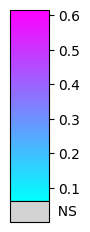

In [109]:

significant_sig_metadata = sig_metadata[sig_metadata.p_value < 0.05]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(0.5, 2.75), gridspec_kw={'height_ratios': [9, 1]})

cmap = mpl.cm.cool
# Use minimum and maximum cs values from significant_sig_metadata
norm = mpl.colors.Normalize(vmin=significant_sig_metadata.cs.min(), vmax=significant_sig_metadata.cs.max())

mapper = cm.ScalarMappable(norm=norm, cmap=cm.cool)

cbl = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='vertical')

# Create a separate color bar for the grey color
cmap_grey = mpl.colors.ListedColormap(['lightgrey'])
norm_grey = mpl.colors.Normalize(vmin=0, vmax=1)
cbl_grey = mpl.colorbar.ColorbarBase(ax2, cmap=cmap_grey, norm=norm_grey, orientation='vertical')


ax2.set_xticks([])
ax2.set_yticks([])

# Add a custom label for not-significant values
ax2.set_ylabel('  NS', fontsize=10, rotation=0, ha='left', va='center', labelpad=0)

# Adjust the space between the color bars to make them touch
plt.subplots_adjust(hspace=0)

plt.savefig('figures/R1_2C_pt2.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/R1_2C_pt2.svg', bbox_inches = 'tight')

plt.show()


In [117]:
len(sig_metadata)

43

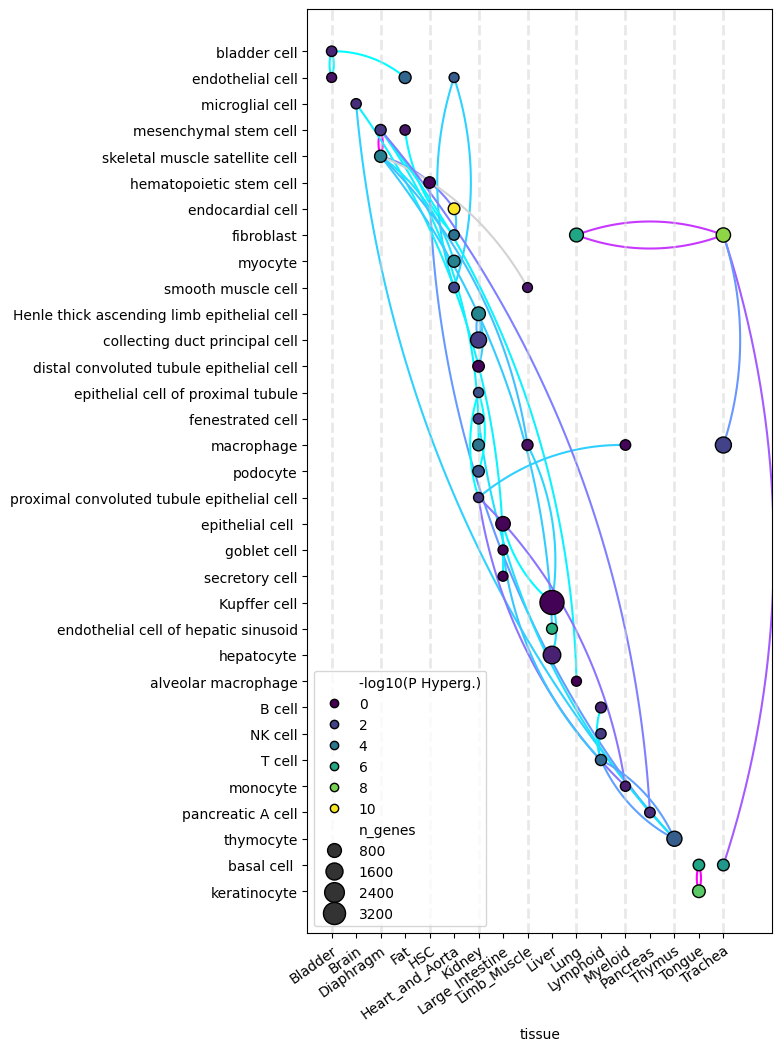

In [132]:
plt.figure(figsize = (6,12))


kwargs = {'edgecolors':'k'}

# hue_legend = ax.get_legend_handles_labels()[0]
# hue_labels = ax.get_legend_handles_labels()[1]
# ax.legend(hue_legend, hue_labels, title="New Hue Title", title_fontsize="13", labelspacing=1.2)


grapher = sig_metadata.copy()
grapher = grapher.rename(columns = {'size': 'n_genes', 'hyp_log10': '-log10(P Hyperg.)'})

ax = sns.scatterplot(data = grapher, x = "tissue", y = "cell", hue = '-log10(P Hyperg.)', size = 'n_genes',
                     sizes = (50, 300), palette = 'viridis', edgecolors = 'black', linewidth = 1)








for i in range(len(sig_metadata)):
    
    s = [sig_metadata.iloc[i].X, sig_metadata.iloc[i].Y]
    e = [sig_metadata.iloc[i].other_X, sig_metadata.iloc[i].other_y]
    
    
    #color = mapper.to_rgba(sig_metadata.iloc[i].cs)
    
    #I now make the lines grey if not significant
    p_value = sig_metadata.iloc[i].p_value
    if p_value < 0.05:
        color = mapper.to_rgba(sig_metadata.iloc[i].cs)
    else:
        color = 'lightgrey'
    
    is_significant = p_value < 0.05
    alpha = 1 if not is_significant else 1.0 #0.2
    
    ax.plot( *draw_arch(s, e, r_mult = 1.5), c=color,ls='-' , zorder = 0, alpha = alpha)

for x, y in enumerate(sig_metadata.tissue.unique()):
    if x%2 == 0:
        ax.axvline(x=y, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')


plt.xlim(right = 18)

plt.ylabel('')

plt.savefig('figures/R1_2C_pt1.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_2C_pt1.svg', bbox_inches = 'tight', transparent = True)

plt.show()

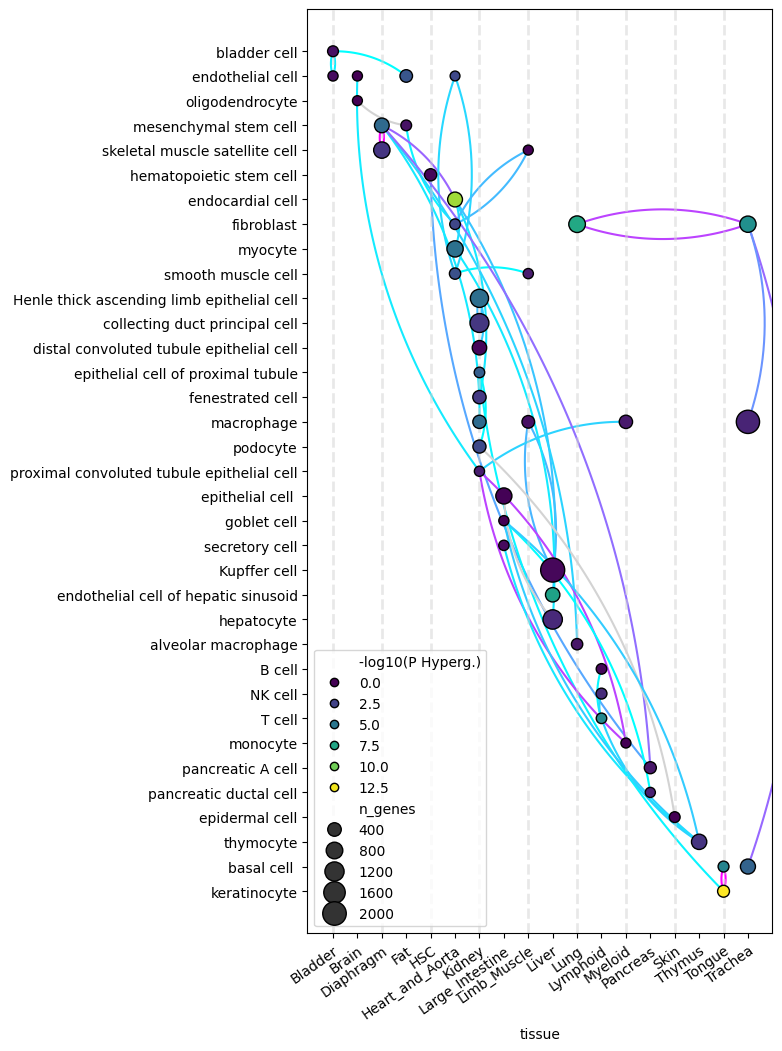

In [37]:
plt.figure(figsize = (6,12))


kwargs = {'edgecolors':'k'}

hue_legend = ax.get_legend_handles_labels()[0]
hue_labels = ax.get_legend_handles_labels()[1]
ax.legend(hue_legend, hue_labels, title="New Hue Title", title_fontsize="13", labelspacing=1.2)


grapher = sig_metadata.copy()
grapher = grapher.rename(columns = {'size': 'n_genes', 'hyp_log10': '-log10(P Hyperg.)'})

ax = sns.scatterplot(data = grapher, x = "tissue", y = "cell", hue = '-log10(P Hyperg.)', size = 'n_genes',
                     sizes = (50, 300), palette = 'viridis', edgecolors = 'black', linewidth = 1)


for i in range(len(sig_metadata)):
    
    s = [sig_metadata.iloc[i].X, sig_metadata.iloc[i].Y]
    e = [sig_metadata.iloc[i].other_X, sig_metadata.iloc[i].other_y]
    
    
    #color = mapper.to_rgba(sig_metadata.iloc[i].cs)
    
    #I now make the lines grey if not significant
    p_value = sig_metadata.iloc[i].p_value
    if p_value < 0.05:
        color = mapper.to_rgba(sig_metadata.iloc[i].cs)
    else:
        color = 'lightgrey'
    
    is_significant = p_value < 0.05
    alpha = 1 if not is_significant else 1.0 #0.2
    
    ax.plot( *draw_arch(s, e, r_mult = 1.5), c=color,ls='-' , zorder = 0, alpha = alpha)

for x, y in enumerate(sig_metadata.tissue.unique()):
    if x%2 == 0:
        ax.axvline(x=y, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')


plt.xlim(right = 18)

plt.ylabel('')

plt.savefig('figures/2C_pt1.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/2C_pt1.svg', bbox_inches = 'tight')

plt.show()

In [43]:
# Filter the significant pairs
significant_pairs = cs_df[cs_df['padj'] <= 0.05]

# Count the number of significant pairs where both cell types are from the same tissue
same_tissue_count = sum(significant_pairs.apply(lambda row: row['tissue_cell1']\
                            .split('__')[0] == row['tissue_cell2'].split('__')[0], axis=1))

# Compute the proportion of significant pairs that are from the same tissue
same_tissue_proportion = same_tissue_count / len(significant_pairs)

print("Proportion of significant pairs that are from the same tissue:", same_tissue_proportion)


Proportion of significant pairs that are from the same tissue: 0.11956521739130435


In [44]:
# Count the number of pairs where both cell types are from the same tissue in the entire dataset
total_same_tissue_count = sum(cs_df.apply(lambda row: row['tissue_cell1']\
                            .split('__')[0] == row['tissue_cell2'].split('__')[0], axis=1))

# Compute the proportion of same-tissue pairs in the entire dataset
total_same_tissue_proportion = total_same_tissue_count / len(cs_df)

print("Proportion of same-tissue pairs in the entire dataset:", total_same_tissue_proportion)


Proportion of same-tissue pairs in the entire dataset: 0.06312292358803986


In [45]:
from scipy.stats import chi2_contingency

# Construct a contingency table
contingency_table = [[same_tissue_count, len(significant_pairs) - same_tissue_count],
                     [total_same_tissue_count - same_tissue_count,
                      (len(cs_df) - len(significant_pairs)) - (total_same_tissue_count - same_tissue_count)]]

# Perform the Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Chi-square test p-value:", p_value)


Chi-square test p-value: 1.6500176537749562e-08


In [46]:
significant_pairs = cs_df[cs_df['padj'] <= 0.05]

# Count the number of significant pairs where both cell types are the same
same_cell_type_count = sum(significant_pairs.apply(lambda row: row['tissue_cell1']\
                            .split('__', 1)[1] == row['tissue_cell2'].split('__', 1)[1], axis=1))

# Compute the proportion of significant pairs with the same cell type
same_cell_type_proportion = same_cell_type_count / len(significant_pairs)

print("Proportion of significant pairs with the same cell type:", same_cell_type_proportion)


Proportion of significant pairs with the same cell type: 0.03260869565217391


In [47]:
# Count the number of pairs where both cell types are the same in the entire dataset
total_same_cell_type_count = sum(cs_df.apply(lambda row: row['tissue_cell1']\
                                .split('__', 1)[1] == row['tissue_cell2'].split('__', 1)[1], axis=1))

# Compute the proportion of same-cell-type pairs in the entire dataset
total_same_cell_type_proportion = total_same_cell_type_count / len(cs_df)

print("Proportion of same-cell-type pairs in the entire dataset:", total_same_cell_type_proportion)


Proportion of same-cell-type pairs in the entire dataset: 0.016611295681063124


In [48]:
# Construct a contingency table for cell types
contingency_table_cell_type = [[same_cell_type_count, len(significant_pairs) - same_cell_type_count],
                               [total_same_cell_type_count - same_cell_type_count,
                                (len(cs_df) - len(significant_pairs)) - (total_same_cell_type_count - same_cell_type_count)]]

# Perform the Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table_cell_type)

print("Chi-square test p-value for cell types:", p_value)


Chi-square test p-value for cell types: 0.004310541413718581


In [139]:
significant_pairs = cs_df[cs_df['padj'] <= 0.05]

cell_type_of_interest = "fibroblast"

# Filter the 'res' DataFrame to keep only the comparisons involving the cell type of interest
res_fibroblast = cs_df[(cs_df['tissue_cell1'].str.contains(cell_type_of_interest)) |\
                     (cs_df['tissue_cell2'].str.contains(cell_type_of_interest))]
significant_pairs_fibroblast = significant_pairs[(significant_pairs['tissue_cell1']\
                                .str.contains(cell_type_of_interest)) |\
                                        (significant_pairs['tissue_cell2'].str.contains(cell_type_of_interest))]
# Count the number of significant pairs with the same cell type among the pairs involving the cell type of interest
same_cell_type_count_fibroblast = sum(significant_pairs_fibroblast.\
                                      apply(lambda row: row['tissue_cell1'].\
                                            split('__', 1)[1] == row['tissue_cell2'].split('__', 1)[1], axis=1))

# Compute the proportion of significant pairs with the same cell type among the pairs involving the cell type of interest
same_cell_type_proportion_fibroblast = same_cell_type_count_fibroblast / len(significant_pairs_fibroblast)

print("Proportion of significant pairs with the same cell type among the pairs involving the cell type of interest:", same_cell_type_proportion_fibroblast)


Proportion of significant pairs with the same cell type among the pairs involving the cell type of interest: 0.039473684210526314


In [140]:
# Count the number of pairs with the same cell type in the entire dataset involving the cell type of interest
total_same_cell_type_count_fibroblast = sum(res_fibroblast.apply(lambda row: row['tissue_cell1']\
                                                .split('__', 1)[1] == row['tissue_cell2'].split('__', 1)[1], axis=1))

# Compute the proportion of same-cell-type pairs in the entire dataset involving the cell type of interest
total_same_cell_type_proportion_fibroblast = total_same_cell_type_count_fibroblast / len(res_fibroblast)

print("Proportion of same-cell-type pairs in the entire dataset involving the cell type of interest:", total_same_cell_type_proportion_fibroblast)


Proportion of same-cell-type pairs in the entire dataset involving the cell type of interest: 0.024390243902439025


In [141]:
# Construct a contingency table for the cell type of interest
contingency_table_fibroblast = [[same_cell_type_count_fibroblast, len(significant_pairs_fibroblast) - same_cell_type_count_fibroblast],
                                [total_same_cell_type_count_fibroblast - same_cell_type_count_fibroblast, (len(res_fibroblast) - len(significant_pairs_fibroblast)) - (total_same_cell_type_count_fibroblast - same_cell_type_count_fibroblast)]]

# Perform the Chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table_fibroblast)

print("Chi-square test p-value for the cell type of interest:", p_value)


Chi-square test p-value for the cell type of interest: 0.4368508360047374


In [142]:
cs_df

,tissue_cell1,tissue_cell2,cs,p_value,padj
0,Bladder__bladder cell,Bladder__endothelial cell,0.084485,2.551099e-06,2.303642e-03
1,Bladder__bladder cell,Brain__microglial cell,0.020911,1.188979e-01,1.073648e+02
2,Bladder__bladder cell,Diaphragm__mesenchymal stem cell,0.021301,1.925817e-01,1.739013e+02
3,Bladder__bladder cell,Diaphragm__skeletal muscle satellite cell,0.045546,5.316620e-03,4.800908e+00
4,Bladder__bladder cell,Fat__endothelial cell,0.069336,6.713713e-10,6.062483e-07
...,...,...,...,...,...
898,Tongue__keratinocyte,Trachea__fibroblast,0.361216,2.944211e-104,2.658623e-101
899,Tongue__keratinocyte,Trachea__macrophage,0.243516,3.486359e-31,3.148183e-28
900,Trachea__basal cell,Trachea__fibroblast,0.414397,2.620658e-150,2.366454e-147
901,Trachea__basal cell,Trachea__macrophage,0.204474,6.002778e-38,5.420509e-35


In [143]:
len(cs_df[cs_df.padj < 0.05])/len(cs_df)

0.40753045404208194

In [144]:
cs_df[cs_df.padj < 0.05]

,tissue_cell1,tissue_cell2,cs,p_value,padj
0,Bladder__bladder cell,Bladder__endothelial cell,0.084485,2.551099e-06,2.303642e-03
4,Bladder__bladder cell,Fat__endothelial cell,0.069336,6.713713e-10,6.062483e-07
5,Bladder__bladder cell,Fat__mesenchymal stem cell,0.063304,1.544938e-09,1.395079e-06
7,Bladder__bladder cell,Heart_and_Aorta__endocardial cell,0.078164,4.875679e-11,4.402738e-08
9,Bladder__bladder cell,Heart_and_Aorta__fibroblast,0.061230,7.244759e-09,6.542018e-06
...,...,...,...,...,...
898,Tongue__keratinocyte,Trachea__fibroblast,0.361216,2.944211e-104,2.658623e-101
899,Tongue__keratinocyte,Trachea__macrophage,0.243516,3.486359e-31,3.148183e-28
900,Trachea__basal cell,Trachea__fibroblast,0.414397,2.620658e-150,2.366454e-147
901,Trachea__basal cell,Trachea__macrophage,0.204474,6.002778e-38,5.420509e-35


In [145]:
sig_metadata

,tissue,cell,size,n_sen,hyp,X,Y,hyp_log10,top_match,cs,p_value,other_X,other_y
0,Bladder,bladder cell,123,3,1.032977e-01,0,0,0.985909,Bladder__endothelial cell,0.084485,2.303642e-03,0,1
1,Bladder,endothelial cell,36,1,2.818629e-01,0,1,0.549962,Bladder__bladder cell,0.084485,2.303642e-03,0,0
2,Brain,microglial cell,97,3,5.950652e-02,1,2,1.225435,Thymus__thymocyte,0.162042,2.337048e-20,14,30
3,Diaphragm,mesenchymal stem cell,247,6,2.634383e-02,2,3,1.579321,Diaphragm__skeletal muscle satellite cell,0.610706,4.183360e-174,2,4
4,Diaphragm,skeletal muscle satellite cell,435,14,4.963053e-05,2,4,4.304251,Diaphragm__mesenchymal stem cell,0.610706,4.183360e-174,2,3
5,Fat,endothelial cell,416,12,4.660581e-04,3,1,3.331560,Bladder__bladder cell,0.069336,6.062483e-07,0,0
6,Fat,mesenchymal stem cell,111,2,2.699024e-01,3,3,0.568793,Heart_and_Aorta__fibroblast,0.076322,2.951182e-10,5,7
7,HSC,hematopoietic stem cell,320,2,7.934784e-01,4,5,0.100465,Pancreas__pancreatic A cell,0.280759,1.659654e-32,13,29
8,Heart_and_Aorta,endocardial cell,351,20,8.279602e-11,5,6,10.081991,Diaphragm__skeletal muscle satellite cell,0.332687,2.831465e-58,2,4
9,Heart_and_Aorta,endothelial cell,50,4,1.123542e-03,5,1,2.949411,Heart_and_Aorta__smooth muscle cell,0.157278,2.662016e-18,5,9


In [146]:
for tissue_cell in list(set(cs_df.tissue_cell1.tolist() + cs_df.tissue_cell2.tolist())):
    temp = cs_df[(cs_df.tissue_cell1 == tissue_cell ) | (cs_df.tissue_cell2 == tissue_cell)]

In [147]:
temp.sort_values('cs', ascending = False).iloc[0]

tissue_cell1     Lymphoid__T cell
tissue_cell2    Thymus__thymocyte
cs                       0.266887
p_value                       0.0
padj                          0.0
Name: 861, dtype: object

In [148]:
test_mat = cs_df.pivot(values = 'cs', index = 'tissue_cell1', columns = 'tissue_cell2')
test_mat

tissue_cell2,Bladder__endothelial cell,Brain__microglial cell,Diaphragm__mesenchymal stem cell,Diaphragm__skeletal muscle satellite cell,Fat__endothelial cell,Fat__mesenchymal stem cell,HSC__hematopoietic stem cell,Heart_and_Aorta__endocardial cell,Heart_and_Aorta__endothelial cell,Heart_and_Aorta__fibroblast,...,Lymphoid__T cell,Myeloid__macrophage,Myeloid__monocyte,Pancreas__pancreatic A cell,Thymus__thymocyte,Tongue__basal cell,Tongue__keratinocyte,Trachea__basal cell,Trachea__fibroblast,Trachea__macrophage
tissue_cell1,,,,,,,,,,,,,,,,,,,,,
Bladder__bladder cell,0.084485,0.020911,0.021301,0.045546,0.069336,0.063304,0.025830,0.078164,0.002940,0.061230,...,0.017767,0.011878,0.012492,0.014056,0.022057,0.024056,0.044115,0.049343,0.023244,0.068599
Bladder__endothelial cell,NaN,0.000000,0.008848,0.016026,0.010412,0.034058,0.015372,0.080833,0.019800,0.056943,...,0.000000,0.000000,0.005095,0.000000,0.008707,0.030914,0.030129,0.002567,0.023470,0.015444
Brain__microglial cell,NaN,NaN,0.012764,0.007497,0.002342,0.003189,0.010941,0.009568,0.010108,0.007918,...,0.004979,0.000000,0.002204,0.006080,0.162042,0.018525,0.020512,0.001711,0.008266,0.002901
Diaphragm__mesenchymal stem cell,NaN,NaN,NaN,0.610706,0.019115,0.025975,0.179501,0.305666,0.023978,0.099216,...,0.061094,0.046710,0.039621,0.336066,0.050194,0.164809,0.235479,0.267096,0.336251,0.058708
Diaphragm__skeletal muscle satellite cell,NaN,NaN,NaN,NaN,0.013478,0.016565,0.184766,0.332687,0.029587,0.097175,...,0.062898,0.054361,0.057725,0.280738,0.050066,0.144998,0.234215,0.273555,0.298498,0.094849
Fat__endothelial cell,NaN,NaN,NaN,NaN,NaN,0.032390,0.020319,0.031926,0.037516,0.008273,...,0.022482,0.013134,0.019032,0.008861,0.024122,0.033337,0.041952,0.020921,0.023860,0.040738
Fat__mesenchymal stem cell,NaN,NaN,NaN,NaN,NaN,NaN,0.024360,0.033506,0.006487,0.076322,...,0.025600,0.013546,0.014395,0.002468,0.029094,0.021694,0.025638,0.017518,0.034771,0.025467
HSC__hematopoietic stem cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082056,0.017570,0.009088,...,0.041440,0.030804,0.107710,0.280759,0.080318,0.069802,0.084550,0.170897,0.127855,0.079810
Heart_and_Aorta__endocardial cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075121,0.182325,...,0.059450,0.073245,0.008973,0.196705,0.041592,0.223816,0.223783,0.201799,0.241123,0.132341


In [149]:

tester = corrs_sig[(corrs_sig.tissue == 'Heart_and_Aorta') & (corrs_sig.cell_type_2 == 'myocyte')].copy()
tester['dif'] = tester.r - tester.rnd_r_q99

tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)

tester

,tissue,cell_type_2,gene1,gene2,r,p,rnd_r_q99,dif
93408,Heart_and_Aorta,myocyte,Camp,Ngp,0.882921,0.000,0.103942,0.778979
93424,Heart_and_Aorta,myocyte,Ngp,Ltf,0.882921,0.000,0.122489,0.760432
93410,Heart_and_Aorta,myocyte,Camp,Ltf,0.862334,0.000,0.115202,0.747132
75370,Heart_and_Aorta,myocyte,Chi3l3,Ltf,0.857825,0.000,0.116845,0.740980
75368,Heart_and_Aorta,myocyte,Chi3l3,Ngp,0.845547,0.000,0.108115,0.737432
...,...,...,...,...,...,...,...,...
1280,Heart_and_Aorta,myocyte,Icos,Ltf,0.194935,0.000,0.144883,0.050053
71710,Heart_and_Aorta,myocyte,Cdh22,Sec1,0.194935,0.000,0.144883,0.050053
61889,Heart_and_Aorta,myocyte,Ctsw,Ltf,0.194935,0.002,0.144883,0.050053
22775,Heart_and_Aorta,myocyte,Ccl7,Ctsw,0.194935,0.000,0.144883,0.050053


In [150]:
import matplotlib.patheffects as PathEffects

### Fig 2B part 1

/tmp/ipykernel_1381197/1839137015.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])


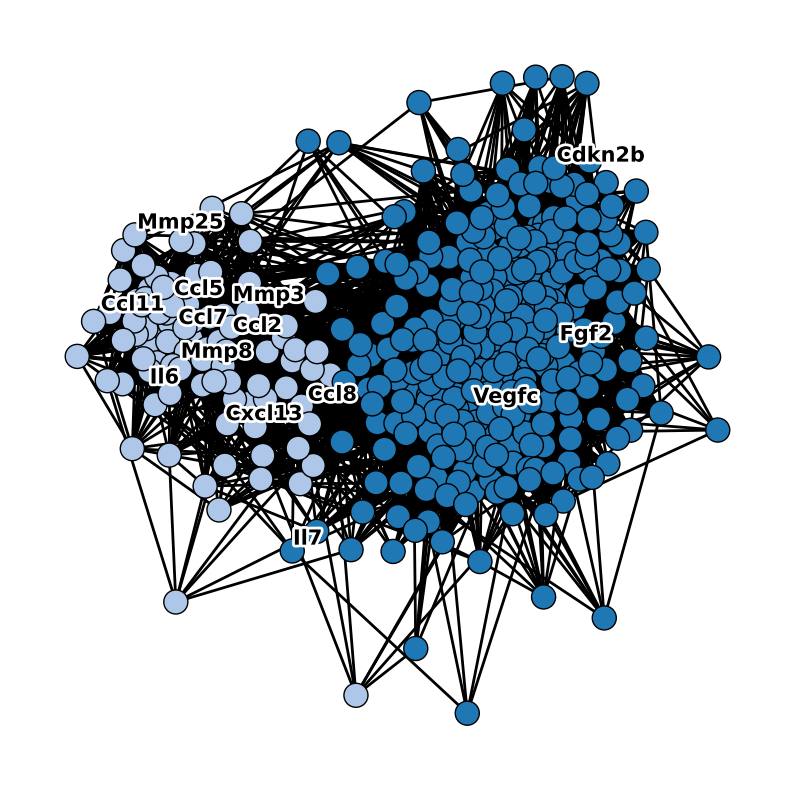

In [156]:
tester = corrs_sig[(corrs_sig.tissue == 'Heart_and_Aorta') & (corrs_sig.cell_type_2 == 'myocyte')].copy()
tester['dif'] = tester.r - tester.rnd_r_q99

tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)


#hub_genes = [x[0] for x in hubs.hubs[('Heart_and_Aorta', 'myocyte')]]
hub_genes = [x[0] for x in signatures[('Heart_and_Aorta', 'myocyte')]]

tester = tester[(tester.gene1.isin(hub_genes)) & (tester.gene2.isin(hub_genes))]

G = nx.Graph()
#G = nx.petersen_graph()



for i, elrow in tester.iterrows():
    G.add_edge(elrow[2], elrow[3], weight=elrow[7])







clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(10,10))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')





nx.draw_networkx_nodes(G, pos, 
                       node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
                       edgecolors = 'k')
nx.draw_networkx_edges(G, pos, width =  2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))

plt.gca().spines[['top', 'right', 'bottom', 'left']].set_visible(False)


plt.savefig('figures/R1_2B_pt1.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_2B_pt1.svg', bbox_inches = 'tight', transparent = True)

plt.show()

/tmp/ipykernel_1719533/447487874.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(elrow[2], elrow[3], weight=elrow[7])


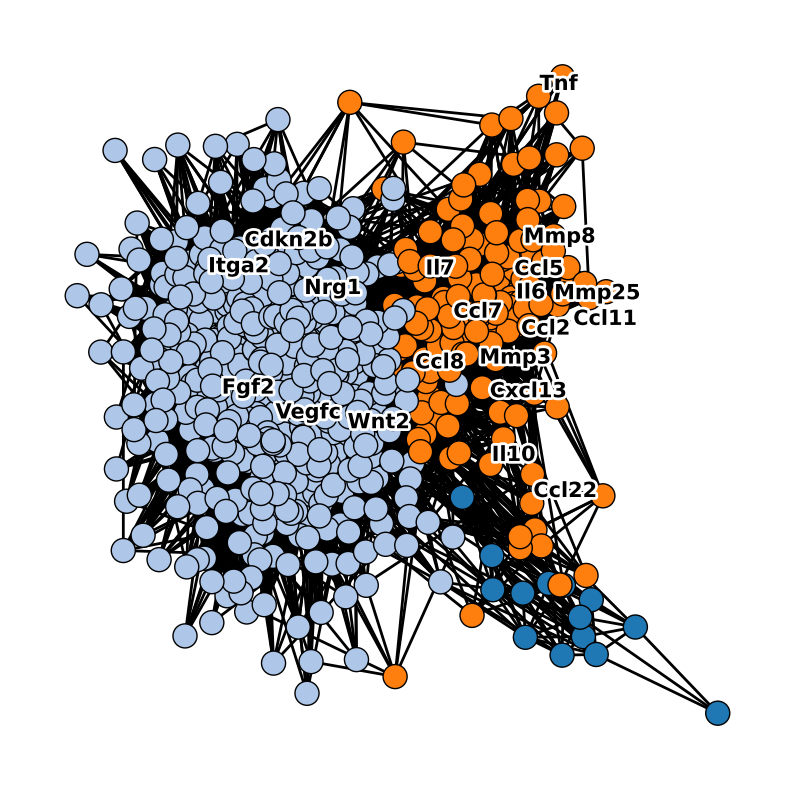

In [56]:
tester = corrs_sig[(corrs_sig.tissue == 'Heart_and_Aorta') & (corrs_sig.cell_type_2 == 'myocyte')].copy()
tester['dif'] = tester.r - tester.rnd_r_q99

tester = tester[(tester.dif > 0.05) & (tester.r > 0.05)].sort_values('dif', ascending = False)


hub_genes = [x[0] for x in hubs.hubs[('Heart_and_Aorta', 'myocyte')]]
tester = tester[(tester.gene1.isin(hub_genes)) & (tester.gene2.isin(hub_genes))]

G = nx.Graph()
#G = nx.petersen_graph()



for i, elrow in tester.iterrows():
    G.add_edge(elrow[2], elrow[3], weight=elrow[7])







clusters = nx_comm.louvain_communities(G, seed=123, resolution = .25)
clusters = [list(x) for x in clusters]


pos = nx.spring_layout(G, seed = 1) #seed = 1

plt.figure(figsize=(10,10))
colors = plt.cm.tab20(range(20))
color_d = {}
Ecolor_d = {}
for combo in list(zip(clusters, colors)):
    for thing in combo[0]:
        color_d[thing] = combo[1]
        if thing not in list(markers):
            Ecolor_d[thing] = combo[1]
        else:
            Ecolor_d[thing] = 'magenta'



node_lables = {k:v for (k,v) in pos.items() if k in markers}

# nx.draw_networkx_labels(G, pos, node_lables, font_size=15, font_family="sans-serif",
#                         font_weight='bold')





nx.draw_networkx_nodes(G, pos, 
                       node_color = [color_d[x[0]] for x in list(G.nodes(data=True))], 
                       edgecolors = 'k')
nx.draw_networkx_edges(G, pos, width =  2)

texts = []
for k in node_lables:
    txt = plt.text(x = node_lables[k][0], y = node_lables[k][1], s = k,
                             fontsize = 15, weight = 'bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
    texts.append(txt)

adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))

plt.gca().spines[['top', 'right', 'bottom', 'left']].set_visible(False)


plt.savefig('figures/2B_pt1.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/2B_pt1.svg', bbox_inches = 'tight')

plt.show()